# Step-by-Step Guide: Create Your First LLM App in Less Than 100 Lines of Code

In this Ocademy tutorial, we will utilize the MIT AI news dataset to construct the knowledge base and use LLM to interact with it. 

Imagine if MIT News📰 were to introduce an AI assistant for their readers, enabling them to quickly search and delve into various technology topics on their website, without the need to comb through numerous archived articles. This tutorial provides a glimpse into how such an assistant could be developed!

As a high-level overview, let's break down the key parts of an LLM app's architecture:

- Embedding models 🧮 convert text into numeric representations that LLMs can understand

- Vector databases 🧑‍💻 store these numeric embeddings for quick lookups and responses

- Orchestration frameworks like LangChain or LlamaIndex 🔧 simplify how different LLMs are queried in sequence

- The LLMs themselves 🧠 are massive models trained on enormous datasets to understand language

- LLMOps 🚀 handles the infrastructure like knowledge bases, data pipelines, caching and developer tools

- Hosting 🖥️ provides cloud infrastructure so users can actually access and interact with the LLM app

A diagram for how everything fits together:


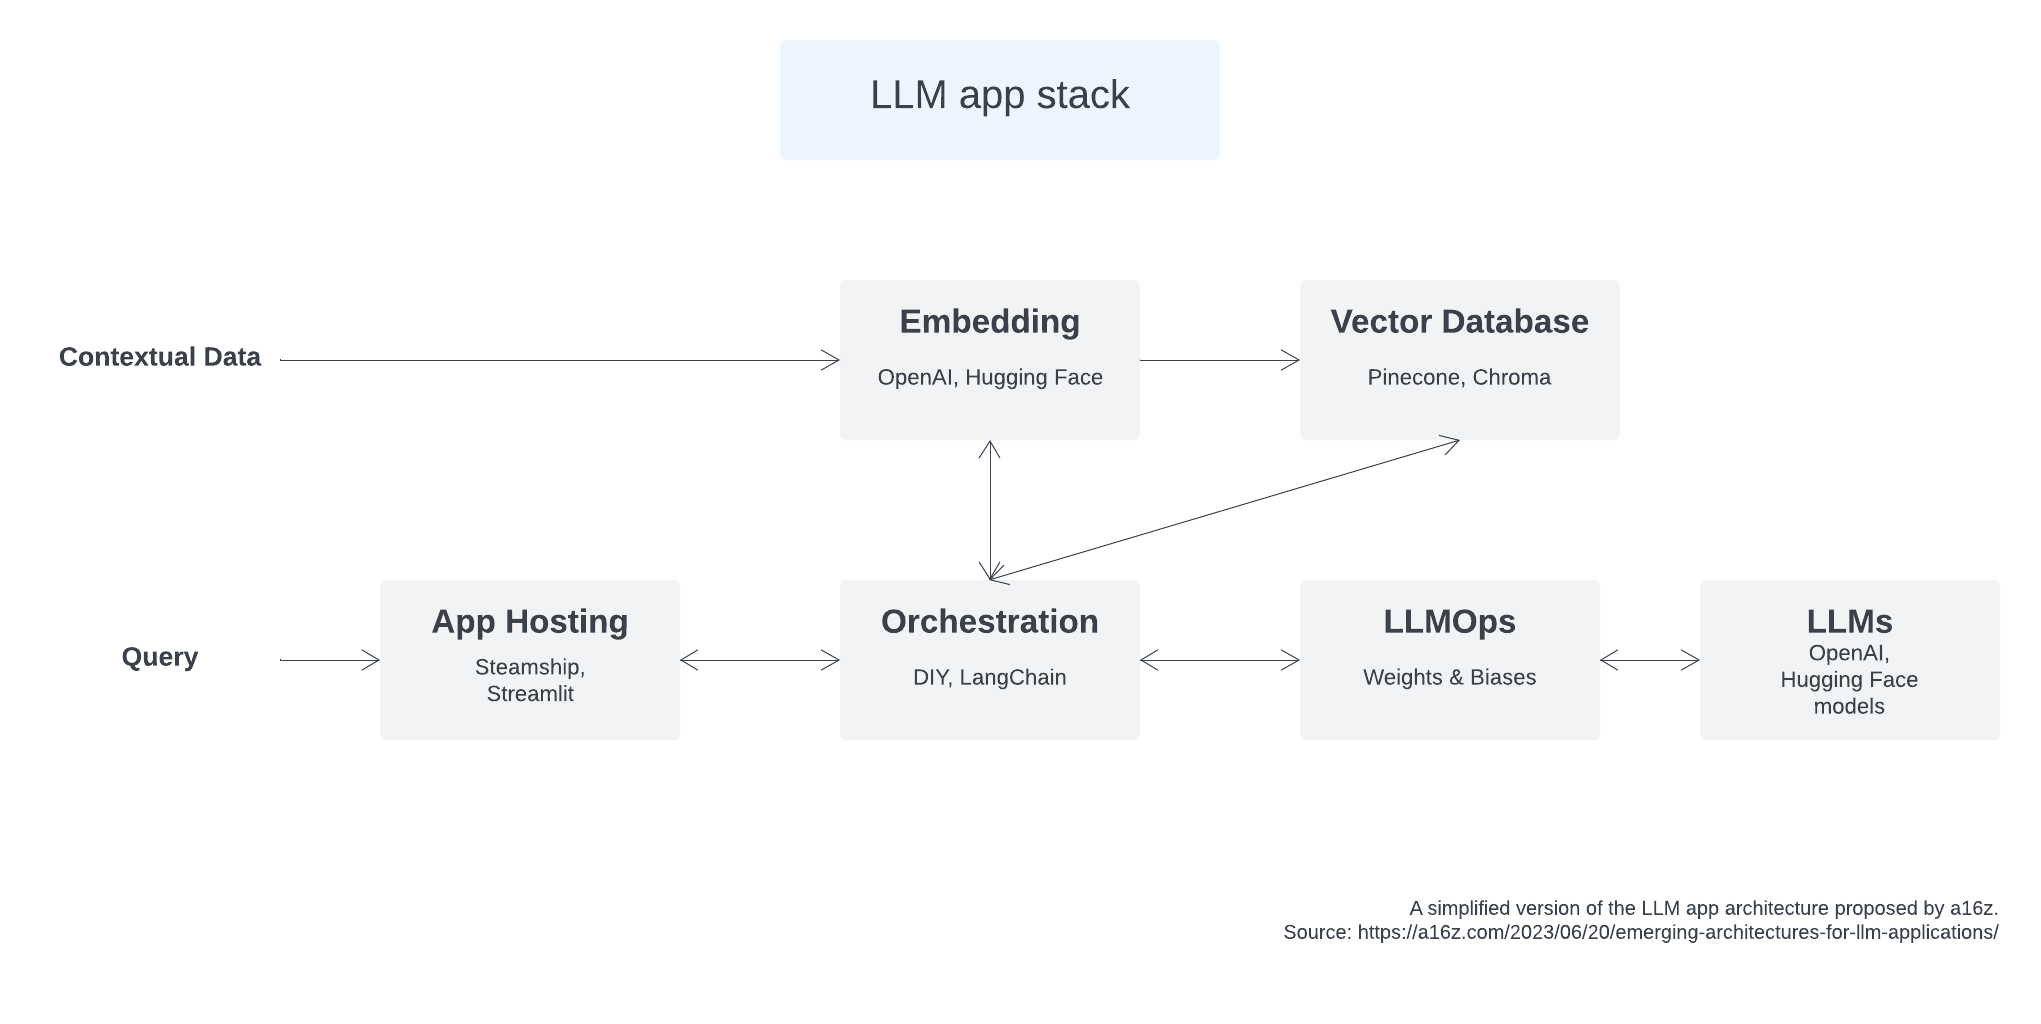


Now let's get started.


First things first. Let's setup the environment.
Here we use dotenv library to load our OPENAI's API key. You need to have a `.env` file containing `OPENAI_API_KEY=""` in the same directory.

In [3]:
# !pip install chromadb
# !pip install dotenv
# !pip install "langchain[llms]"
# !pip install openai
# !pip install sentence_transformers
# !pip install tiktoken

In [11]:
%reload_ext dotenv
%reload_ext chromadb
%reload_ext langchain
%reload_ext openai
%reload_ext sentence_transformers
%reload_ext tiktoken

In [15]:
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

True

# First, contextual data



MIT publishes News about technologies since 90s. The Dataset we use contains News specially about topic "AI", from 1994 to 2023.

Credit: [Kaggle MIT AI News](https://www.kaggle.com/datasets/deepanshudalal09/mit-ai-news-published-till-2023?resource=download), for educational purpose only. 

In [17]:
import pandas as pd
news = pd.read_csv("./articles.csv", index_col=False)
news.head()

,Unnamed: 0,Published Date,Author,Source,Article Header,Sub_Headings,Article Body,Url
0,0,"July 7, 2023",Adam Zewe,MIT News Office,Learning the language of molecules to predict ...,This AI system only needs a small amount of da...,['Discovering new materials and drugs typicall...,https://news.mit.edu/2023/learning-language-mo...
1,1,"July 6, 2023",Alex Ouyang,Abdul Latif Jameel Clinic for Machine Learning...,MIT scientists build a system that can generat...,"BioAutoMATED, an open-source, automated machin...",['Is it possible to build machine-learning mod...,https://news.mit.edu/2023/bioautomated-open-so...
2,2,"June 30, 2023",Jennifer Michalowski,McGovern Institute for Brain Research,"When computer vision works more like a brain, ...",Training artificial neural networks with data ...,"['From cameras to self-driving cars, many of t...",https://news.mit.edu/2023/when-computer-vision...
3,3,"June 30, 2023",Mary Beth Gallagher,School of Engineering,Educating national security leaders on artific...,"Experts from MIT’s School of Engineering, Schw...",['Understanding artificial intelligence and ho...,https://news.mit.edu/2023/educating-national-s...
4,4,"June 30, 2023",Adam Zewe,MIT News Office,Researchers teach an AI to write better chart ...,A new dataset can help scientists develop auto...,['Chart captions that explain complex trends a...,https://news.mit.edu/2023/researchers-chart-ca...


In [22]:
# basic data cleaning: remove square bracket
news['Article Body'] = news['Article Body'].str.replace("[\[\]]", "", regex=True)

In [27]:
print(news.shape)
print(news['Article Body'].str.len().describe())

(1018, 8)
count     1018.000000
mean      5250.654224
std       2779.689887
min          0.000000
25%       3075.500000
50%       5603.000000
75%       7210.250000
max      17331.000000
Name: Article Body, dtype: float64


## Next up, let's load the documents

Here, we use the `DataFrameLoader` in `LangChain` to create the document, since our original data comes with `.csv` format. However, there are various loaders available for different sources, such as text files, HTML, Markdown, JSON and even PDFs. For their usage, check out the [LangChain documents](https://python.langchain.com/docs/modules/data_connection/document_loaders/).

In [107]:
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import Chroma

DOC_NUM = 100 # here I cap the length for quick iteration
df_loader = DataFrameLoader(news.head(DOC_NUM), page_content_column="Article Body")
docs = df_loader.load()

# Now create the embedding

What is embedding? It's simply a numerical representation of any data. The embedding process involves capturing the semantic meaning of the input (in our case, texts) and placing similar inputs close together in the embedding space, allowing for easy comparison and analysis of the information.

The embedding model does the work of turning data into numerical representation, which takes the form of vectors.

* 🧱 splitting: As the first step, we will need to divide the document into blocks to later feed to the embedding model. Here, we use LangChain's `RecursiveCharacterTextSplitter` to chunk the article text. _Why recursive you should ask?_ Well, this is due to some quirkiness in the format of our data. For simpler-formatted text, `CharacterTextSplitter` should suffice.

* 🎯 chunking strategy: A good article by pinecone about this: https://www.pinecone.io/learn/chunking-strategies/ But basically the `chunk_size` and `chunk_overlap` parameters can be used to control the granularity of the text splitting. The optimal values for these parameters depend on various factors, including the size and complexity of the documents, the specific use case, and the available computing resources.

In [108]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators = ["',\s+'", "\n\n", "\n", " "],
    chunk_size = 1000,
    chunk_overlap = 100,
    length_function = len,
    is_separator_regex = True,
)
texts = text_splitter.split_documents(docs)

Now, instantiate the embedding model. Here, we use an open source Hugging Face model; there are other options availabe such as OpenAI, Cohere, for which you will write functions like this:
```python
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
```

In [89]:
from langchain.embeddings import HuggingFaceEmbeddings
embedding_function = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

Let's call the embedding model on the first piece of text in our documents and see what it does. As you can see, the `query_result` is a vector of numerical numbers.


In [103]:
# Turn the first text chunk into a vector with the embedding
query_result = embedding_function.embed_query(texts[0].page_content)
print(query_result)

[-0.08029699325561523, -0.08065493404865265, 0.018059276044368744, 0.032889898866415024, 0.019862568005919456, -0.017788495868444443, -0.0479583665728569, 0.02034035325050354, -0.003369471523910761, -0.019730767235159874, -0.05397197976708412, -0.028060955926775932, -0.033454909920692444, 0.05161232501268387, -0.06324969977140427, 0.029960889369249344, -0.0068223439157009125, 0.06033194437623024, -0.0667320191860199, -0.055941399186849594, 0.012173715978860855, 0.05964687466621399, 0.0953216701745987, 0.008063014596700668, 0.011641476303339005, 0.07151490449905396, 0.03841050714254379, -0.038250427693128586, -0.03261560574173927, -0.032569803297519684, 0.07426116615533829, 0.0034182798117399216, -0.04425995796918869, -0.027609990909695625, 0.02255490981042385, 0.02317224256694317, -0.06794223189353943, 0.046671509742736816, 0.041355330497026443, -0.046351443976163864, 0.020062889903783798, -0.057135675102472305, 0.01833488792181015, 0.047480229288339615, 0.09442918747663498, 0.02262443

Finally, let's generate embeddings for the entire documents and save to vector database.
We use Chroma in this case. Pinecone, Qdrant and FAISS are also popular choices.

In [105]:
from langchain.vectorstores import Chroma
# load it into Chroma
db = Chroma.from_documents(texts, embedding_function)

# do a simple vector similarity search
query = "What are the progress of predicting molecular properties"
results = db.similarity_search(query)
print(results[0].page_content)

', 'By contrast, the system created by the MIT researchers can effectively predict molecular properties using only a small amount of data. Their system has an underlying understanding of the rules that dictate how building blocks combine to produce valid molecules. These rules capture the similarities between molecular structures, which helps the system generate new molecules and predict their properties in a data-efficient manner.', 'This method outperformed other machine-learning approaches on both small and large datasets, and was able to accurately predict molecular properties and generate viable molecules when given a dataset with fewer than 100 samples.', '“Our goal with this project is to use some data-driven methods to speed up the discovery of new molecules, so you can train a model to do the prediction without all of these cost-heavy experiments,” says lead author Minghao Guo, a computer science and electrical engineering (EECS) graduate student.


# Finally, "chain" the LLM and the vector database

This is to enable question and answering with LLM, over our contextual data in the vector database.
For LLM, we use OpenAI API. Alternatively, you can choose `huggingface_hub` or `langchain.llms` for open source options such a Llama 2, GPT4All, Dolly 2.0.

In [117]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0.3,
)
# set chain_type to stuff: The simplest option, it just takes the documents it deems appropriate and uses them in the prompt to pass to the model.
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())


Now, let's try to ask a question!

In [118]:
query = "What are the progress of predicting molecular properties"
qa.run(query)

'The researchers from MIT and the MIT-Watson AI Lab have developed a new framework that can predict molecular properties more efficiently than traditional deep-learning approaches. Their system has an underlying understanding of the rules that govern how building blocks combine to form molecules, allowing it to generate new molecules and accurately predict their properties using only a small amount of data. This method outperformed other machine-learning approaches on both small and large datasets, and it was able to accurately predict molecular properties and generate viable molecules even with fewer than 100 samples. The system learns the "language" of molecules, known as a molecular grammar, and uses this knowledge to predict properties more efficiently. The researchers have also demonstrated the effectiveness of their approach in predicting physical properties of polymers. Overall, their work shows promising progress in predicting molecular properties using machine learning.'

# Final touch, prompt template

[Prompt engineering](https://www.pinecone.io/learn/series/langchain/langchain-prompt-templates/) is a crucial aspect of working with language models, as it directly impacts the quality and relevance of the generated text. LangChain simplifies prompt engineering through powerful features for creating and customizing prompt templates. Let's try it out.



In [119]:
from langchain.prompts import PromptTemplate

prompt_template = """As a reporter who stays abreast with AI trends,
you should answer user inquiries based on the context provided and avoid making up answers.
If you don't know the answer, simply state that you don't know.

{context}

Question: {question}"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": PROMPT},
)

# Finally, let's ask questions!
query = "Can AI make art?"
print(qa.run(query))

Yes, AI can make art. The field of AI-generated art has been developing for several decades, with early attempts dating back to the 1960s. Over time, models and algorithms have become more sophisticated, allowing AI systems to create visual and textual art. However, there are ongoing debates and discussions surrounding copyright, disinformation, biases, and the distinction between AI and human creativity. Artists and researchers are exploring the potential of AI as a new medium for artistic expression.


🙌There you have it, your first LLM app is finished with fewer than 100 lines of code!

But don't stop here, make your own changes or try to add more components. There are many pieces we haven't touched upon:
- Try more open-source models from Hugging Face 
- Check out [agent](https://python.langchain.com/docs/modules/agents/), which can enable your LLM app to "take action"
- Try different data types other than csv files
- Try to host this app on either [Streamlit](https://streamlit.io) or [Steamship](https://steamship.com), create engaging UI/UX for it.

Let us know what you make!